## Recommendations in notebook writing

Notebooks are a great tool for data and model exploration. But in that process a lot of Python garbage can get into them as a consequence of the trial and error process.

But once these tasks are done and one arrives to final ideas and insights on the problem under study, the notebook should be **thoroughly cleaned** and the notebook should **concentrate on the insights and conclussions** without, of course, throwing away the good work done.

Below there are a few guidelines about this.

* Put the useful bits of your code as functions on a **Python module** (and make it a script, if needed) that is imported at the notebook's beginning. 
* Of course that module should be **properly documented** and **formatted** (try to learn about PEP 8 if you are going to write a lot of Python).
* Leave in the notebook **as little code as possible**, ideally one- or two-line cells calling a function, plotting results or so on.
* **Avoid boilerplate code**. If needed, put it in a module.
* Put on the notebook some way to **hide/display the code** (an example is shown below).
* The displayed information **should be just that, informative**. So forget about large tables, long output cells, dataframe or array displays and so on.
* Emphasize **insights and conclusions**, using as much markdown as needed to clarify and explain them.
* Make sure that **number cells are consecutive starting at 1.**
* And, of course, make sure that **there are no errors left**. To avoid these last pitfalls, run `Kernel\Restart Kernel and Run All Cells` as often as needed.

And notice that whoever reads your notebook is likely to toggle off your code and consider just the markdown cells. Because of this, once you feel that your notebook is finished,
* let it rest for one day, 
* then open it up, toggle off the code 
* and read it to check **whether it makes sense to you**.

If this is not the case, **the notebook is NOT finished!!!**

Following these rules you are much more likely to get good grades at school (and possibly also larger bonuses at work).

In [1]:
from IPython.display import HTML

HTML('''
<script>code_show=true; 

function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show or hide your raw code."></form>
''')

# Simple Data Analysis and Linear and MLP Regression Modelling

## The `housing` problem

We want to predict median house values in suburbs of Boston.

Accesible en https://archive.ics.uci.edu/ml/datasets/Housing

### Attribute Information:

1. CRIM: per capita crime rate by town 
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft. 
3. INDUS: proportion of non-retail business acres per town 
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
5. NOX: nitric oxides concentration (parts per 10 million) 
6. RM: average number of rooms per dwelling 
7. AGE: proportion of owner-occupied units built prior to 1940 
8. DIS: weighted distances to five Boston employment centres 
9. RAD: index of accessibility to radial highways 
10. TAX: full-value property-tax rate per \$10,000 
11. PTRATIO: pupil-teacher ratio by town 
12. B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town 
13. LSTAT: % lower status of the population 
14. MEDV: Median value of owner-occupied homes in \$1000's

**Lately it has been pointed out that this dataset may present ethical and methodological problems with respect the `B` variable.**  
See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html for more info.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import time
import pickle
import gzip

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_boston

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

## Data Loading

The dataset is preloaded in the scikit-learn library but will disappear soon. A copy can be found from the lib.stat site a CMU.

Alternatively, a smaller dataset also with the `B` variable can be downloaded from the UCI archive.
The UCI file file has 484 data points, the scikit-learn has 506, i.e., 22 more.
The UCI patterns correspond to the scikit patterns starting at row 22. 

##### From UCI

In [4]:
boston_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', \
                'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', \
                'MEDV']
source = 'scikit'
    
if source == 'uci':
    print("reading from the uci site ...")
    data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    df_housing_u = raw_df
    df_housing_u.columns = boston_names
    
elif source == 'cmu':
    print("reading from the cmu site ...")
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

    df_data = pd.DataFrame(data=data)
    df_target = pd.DataFrame(data=target)
    df_housing_c = pd.concat([df_data, df_target], axis=1)
    df_housing_c.columns = boston_names
    
elif source == 'scikit':
    print("loading from scikit datasets  ...")
    boston = load_boston()

    df_housing_s = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
    df_housing_s['MEDV'] = boston['target']
    #df_housing.drop(columns=['B'], inplace=True)

    vars_housing   = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', \
                      'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT']
    target_housing = ['MEDV']

loading from scikit datasets  ...


In [5]:
boston['data'].shape
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

#### Just for checking

To check the coincidences between the Boston datasets, yank the following two cells.

print(df_housing.shape, df_housing_u.shape, df_housing_l.shape)
print(df_housing.columns, df_housing_u.columns, df_housing_l.columns, )

var = 'B'
plt.plot(df_housing[var][22:], df_housing_u[var], '-')
plt.show()
plt.plot(df_housing[var], df_housing_l[var], '-')

## Data Exploration, Visualization and Correlations

Descriptive statistics, boxplots and histograms

In [6]:
df_housing = df_housing_s

dir(df_housing)

### Descriptive analysis

In [7]:
df_housing.describe().round(decimals=2).T

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.61,8.60,0.01,0.08,0.26,3.68,88.98
ZN,506.0,11.36,23.32,0.00,0.00,0.00,12.50,100.00
INDUS,506.0,11.14,6.86,0.46,5.19,9.69,18.10,27.74
CHAS,506.0,0.07,0.25,0.00,0.00,0.00,0.00,1.00
NOX,506.0,0.55,0.12,0.38,0.45,0.54,0.62,0.87
RM,506.0,6.28,0.70,3.56,5.89,6.21,6.62,8.78
AGE,506.0,68.57,28.15,2.90,45.02,77.50,94.07,100.00
DIS,506.0,3.80,2.11,1.13,2.10,3.21,5.19,12.13
RAD,506.0,9.55,8.71,1.00,4.00,5.00,24.00,24.00
TAX,506.0,408.24,168.54,187.00,279.00,330.00,666.00,711.00


THere are no  missing values and value ranges appear to be reasonable.

## Boxplots, histograms and scatterplots

### Boxplots

We normalize the data so that all boxplots are in a similar scale.

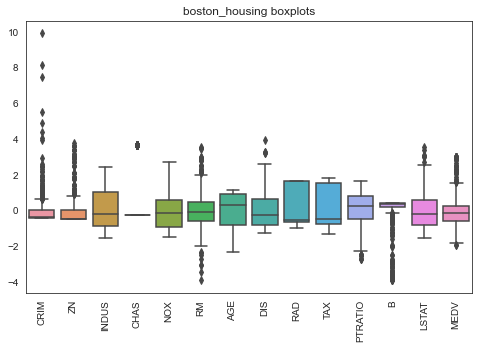

In [8]:
#normalizamos para tener rangos uniformes en histogramas
df_housing_normalizado = (df_housing - df_housing.mean()) / df_housing.std() 

plt.figure( figsize=(8, 5))
sns.set_style("white")
#bx_plot = sns.boxplot(data=df_housing)
bx_plot = sns.boxplot(data=df_housing_normalizado)
#bx_plot = sns.boxplot(data=df_housing)
plt.title("boston_housing boxplots")
plt.xticks(rotation=90)
plt.show()

### Histograms and scatterplots

Histograms and scatter plots against the target of first 7 fatures.

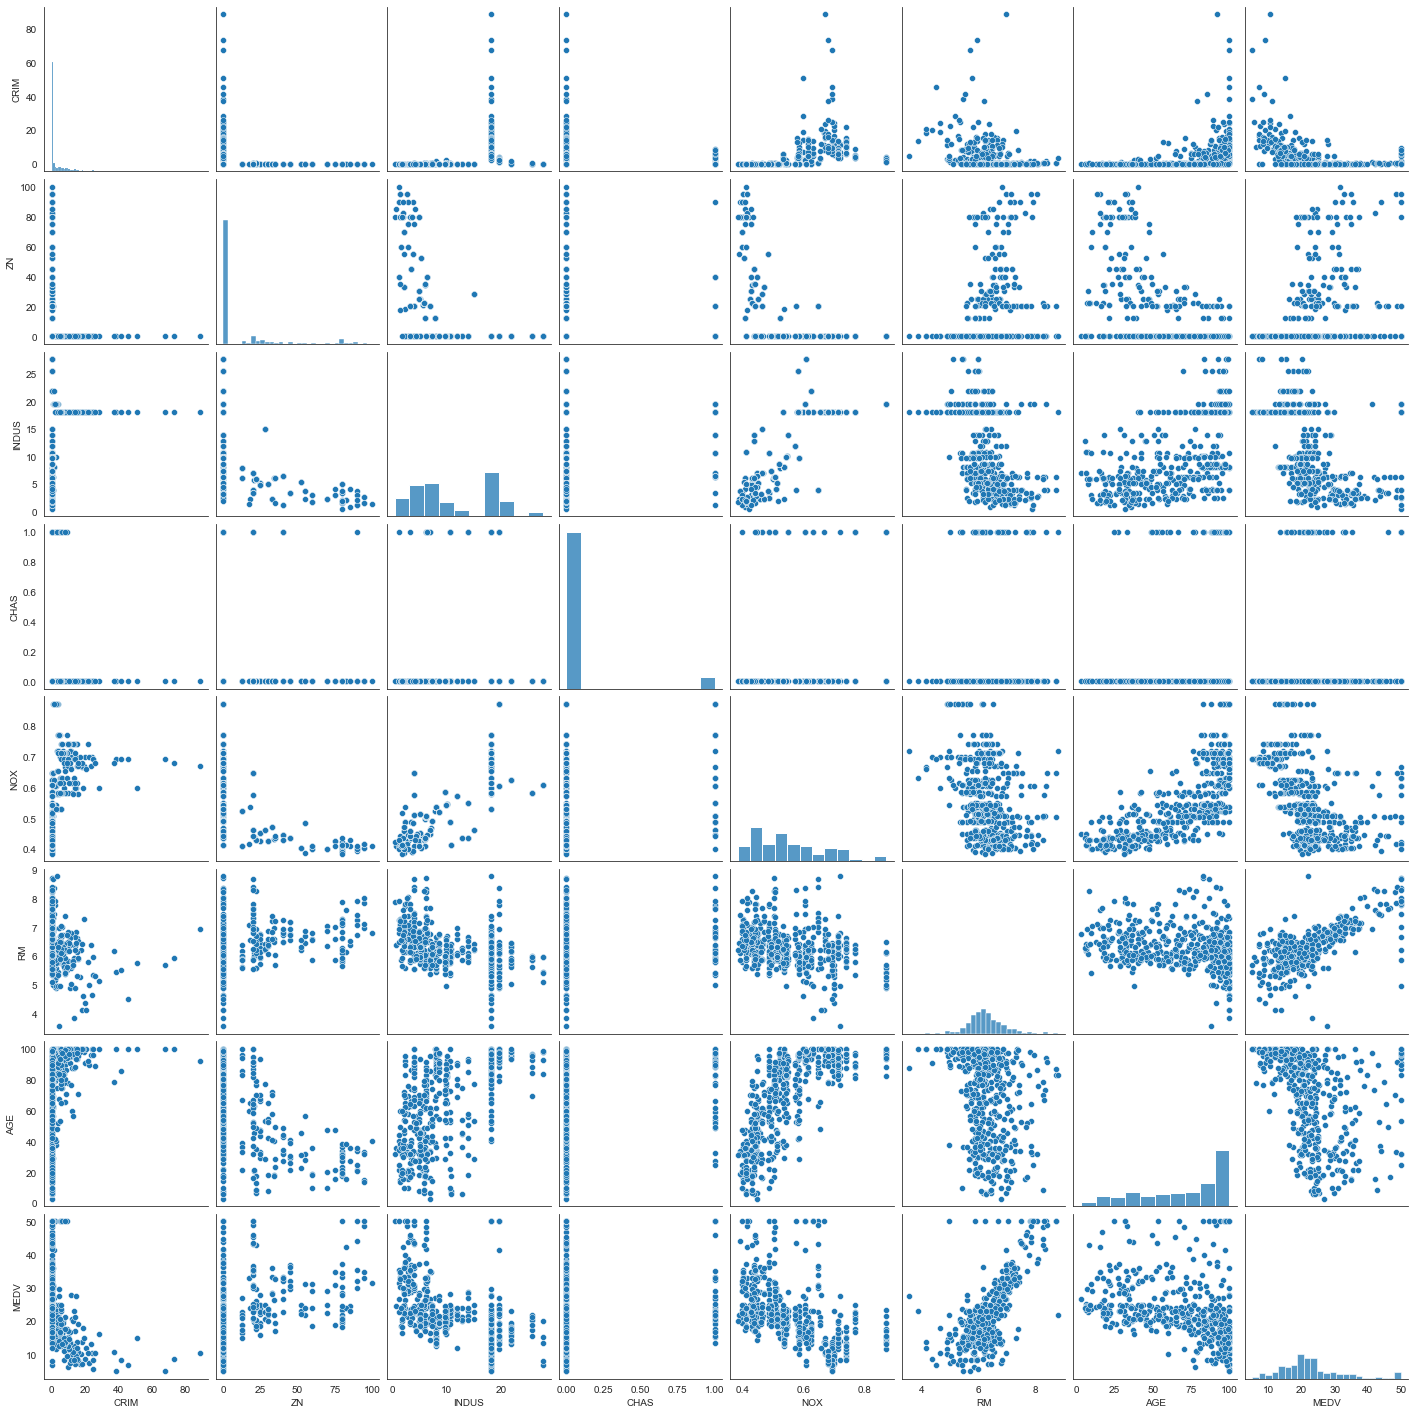

In [9]:
vars_housing = list(df_housing.columns[ : -1])
num_vars_to_show = 7 
pair_plot = sns.pairplot( df_housing[ vars_housing[ : num_vars_to_show] + target_housing] )
plt.show()

Histograms and scatter plots against the target of remaining features.

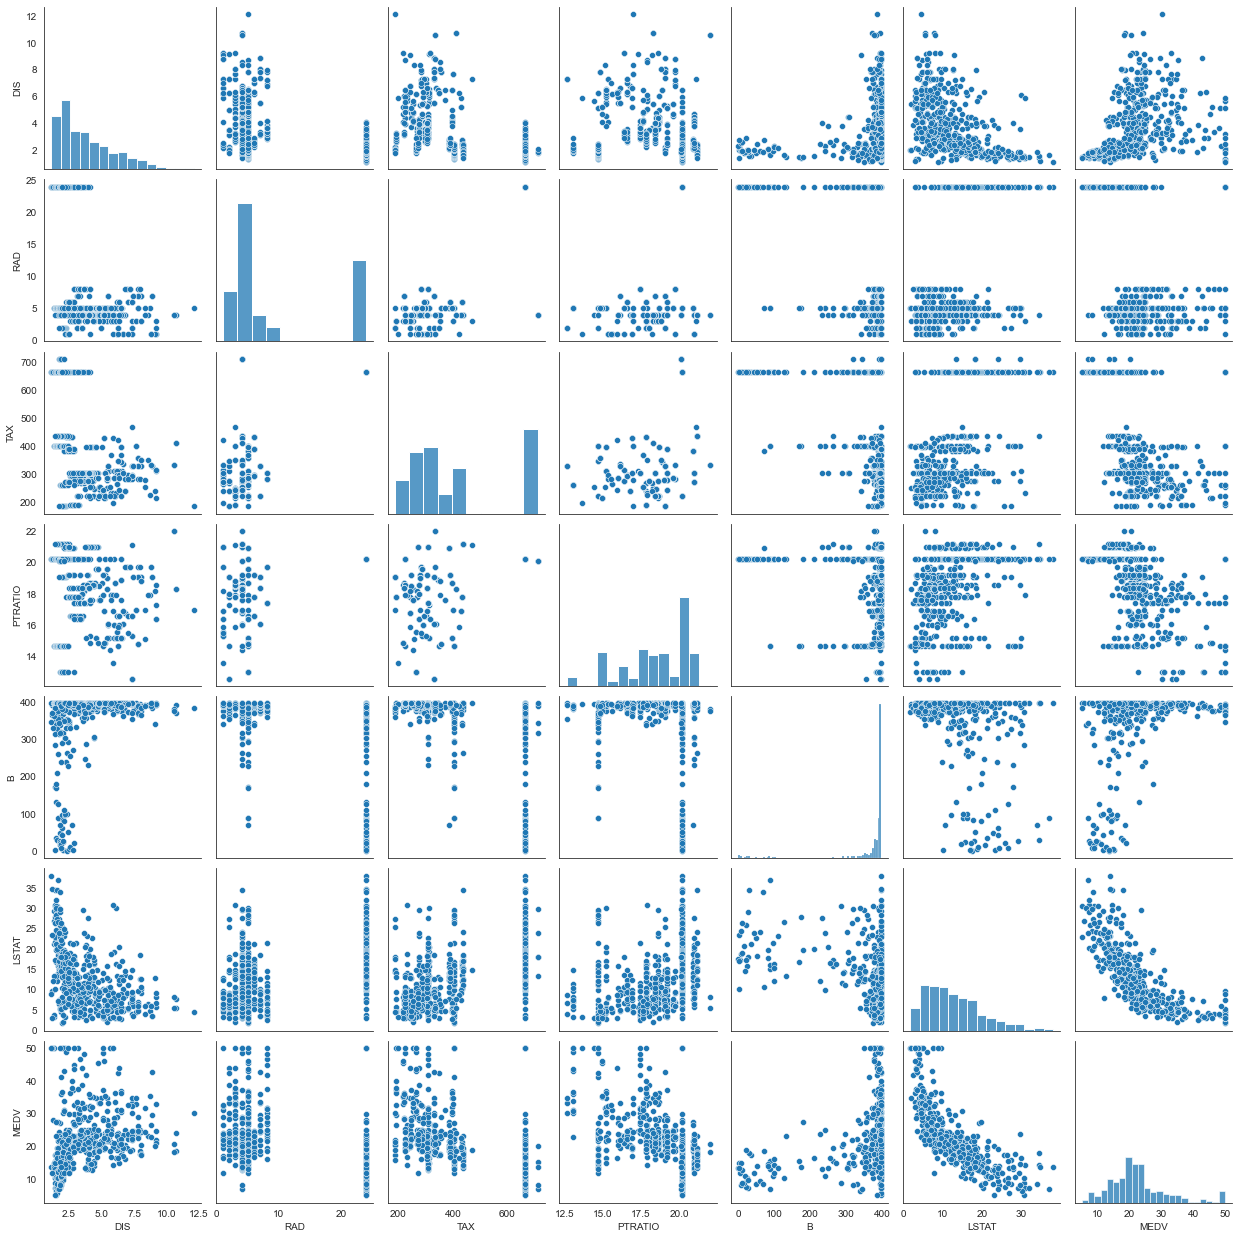

In [10]:
pair_plot = sns.pairplot( df_housing[ vars_housing[ num_vars_to_show: ] + target_housing] )
plt.show()

A few variables seem to have a linear relationship with the target.

### Correlations

In [11]:
df_housing.corr().round(decimals=3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000,-0.200,0.407,-0.056,0.421,-0.219,0.353,-0.380,0.626,0.583,0.290,-0.385,0.456,-0.388
ZN,-0.200,1.000,-0.534,-0.043,-0.517,0.312,-0.570,0.664,-0.312,-0.315,-0.392,0.176,-0.413,0.360
INDUS,0.407,-0.534,1.000,0.063,0.764,-0.392,0.645,-0.708,0.595,0.721,0.383,-0.357,0.604,-0.484
CHAS,-0.056,-0.043,0.063,1.000,0.091,0.091,0.087,-0.099,-0.007,-0.036,-0.122,0.049,-0.054,0.175
NOX,0.421,-0.517,0.764,0.091,1.000,-0.302,0.731,-0.769,0.611,0.668,0.189,-0.380,0.591,-0.427
RM,-0.219,0.312,-0.392,0.091,-0.302,1.000,-0.240,0.205,-0.210,-0.292,-0.356,0.128,-0.614,0.695
AGE,0.353,-0.570,0.645,0.087,0.731,-0.240,1.000,-0.748,0.456,0.506,0.262,-0.274,0.602,-0.377
DIS,-0.380,0.664,-0.708,-0.099,-0.769,0.205,-0.748,1.000,-0.495,-0.534,-0.232,0.292,-0.497,0.250
RAD,0.626,-0.312,0.595,-0.007,0.611,-0.210,0.456,-0.495,1.000,0.910,0.465,-0.444,0.489,-0.382
TAX,0.583,-0.315,0.721,-0.036,0.668,-0.292,0.506,-0.534,0.910,1.000,0.461,-0.442,0.544,-0.469


Una imagen (o un heatmap) vale más que mil palabras

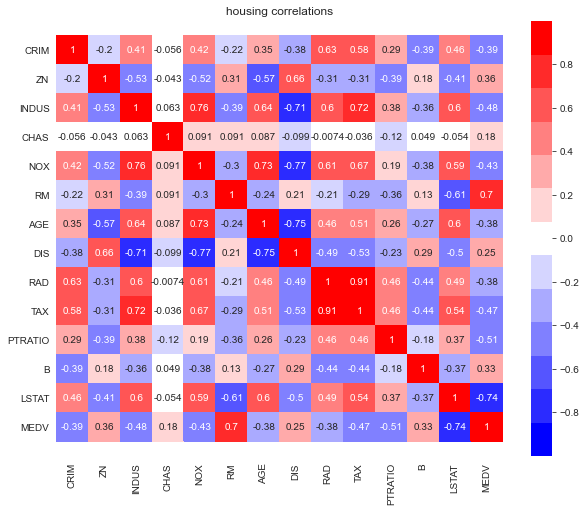

In [12]:
# definir el color map
n_colors = 13
cMap = plt.cm.get_cmap("bwr",lut=n_colors ) 

# definir el heatmap
fig = plt.figure( figsize=(10, 8))
plt.title('housing correlations')
#plt.colorbar(cMap, ticks=[-1, 0, 1])
h_map = sns.heatmap(df_housing.corr().values, 
                    vmin=-1., vmax=1., 
                    cmap=cMap,
                    annot=True,
                    xticklabels=list(df_housing.columns),
                    yticklabels=list(df_housing.columns))
plt.xticks(rotation=90) 

# poner ticks en la barra de color
cbar = h_map.collections[0].colorbar
l_ticks = [k/10. for k in range(-8, 9, 2)]
cbar.set_ticks(l_ticks)

# arreglar cosillas
bottom, top = h_map.get_ylim()
h_map.set_ylim(bottom + 0.5, top - 0.5)

# generar el dibujo
plt.show()

In [13]:
print( ( df_housing.corr()['MEDV'].abs().round(3).sort_values(ascending=False).T) )

MEDV       1.000
LSTAT      0.738
RM         0.695
PTRATIO    0.508
INDUS      0.484
TAX        0.469
NOX        0.427
CRIM       0.388
RAD        0.382
AGE        0.377
ZN         0.360
B          0.333
DIS        0.250
CHAS       0.175
Name: MEDV, dtype: float64


## Ridge Regression

To get started, we define and fit a first model, plot its coefficients and measure errors (though not in a correct way).

model intercept: 22.532806


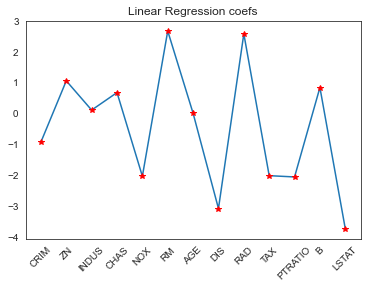

In [14]:
std_sc = StandardScaler()
x = std_sc.fit_transform(boston['data'])
y = boston['target']

lr_m =  Ridge()
#ajuste sobre la muestra completa, sin split train-test
lr_m.fit(x, y)

print("model intercept: %f" % lr_m.intercept_)

plt.xticks(range(len(vars_housing)), vars_housing, rotation=45)
plt.title('Linear Regression coefs')
_ = plt.plot(lr_m.coef_.T, '-', lr_m.coef_.T, 'r*')

MAE: 3.226	R^2: 0.741


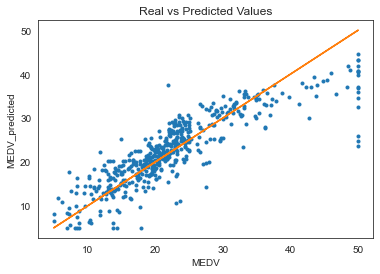

In [15]:
y_pred = np.clip(lr_m.predict(x), 5.,  50.)

print("MAE: %.3f\tR^2: %.3f" % (mean_absolute_error(y, y_pred), lr_m.score(x, y)))

plt.title('Real vs Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_predicted')
_ = plt.plot(y, y_pred, '.', y, y, '-')

### Estimating model performance

We get a more realistic evaluation through Cross Validation over 10 random folds.

In [16]:
n_folds = 10
kf = KFold(n_folds, shuffle=True)

scores = cross_val_score(lr_m, x, y, scoring="neg_mean_absolute_error", cv=kf, n_jobs=-1)

print("mae_mean: %.3f\t\tmae_std: %.3f" % (-scores.mean(), scores.std()))
print("scores:\n", -np.round(scores, 3))

mae_mean: 3.445		mae_std: 0.481
scores:
 [4.271 2.72  3.189 3.077 3.042 3.589 4.27  3.284 3.576 3.429]


### Finding the optimal `alpha` by Grid Search CV

 We select the ridge parameter `alpha` by CV.

In [17]:
# First iteration to find alpha

# define folds
n_folds = 10
kf = KFold(n_folds, shuffle=True)

# define param_grid
l_alpha = [2.**k for k in range(-6, 10)]
param_grid = {'alpha': l_alpha}

# define grid search
lr_m = Ridge()
ridge_alpha_search = GridSearchCV(lr_m, 
                                  param_grid=param_grid, 
                                  cv=kf, 
                                  scoring='neg_mean_absolute_error',
                                  n_jobs=-1, 
                                  verbose=1)

_ = ridge_alpha_search.fit(x, y)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


### Analyzing GridSearchCV results

We check the adequacy of the best hyperparameter and plot the CV errors with respect to `alpha`.

alpha_range: 0.02 - 512.00
alpha = 32.00
best_cv_mae = 3.354


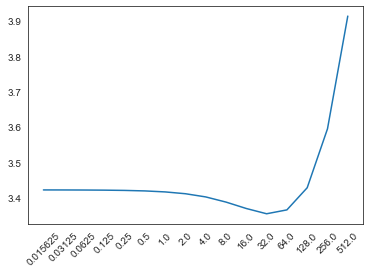

In [18]:
print("alpha_range: %.2f - %.2f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))
print('alpha = %.2f' % (ridge_alpha_search.best_params_['alpha']))
print('best_cv_mae = %.3f' % (-ridge_alpha_search.best_score_))

plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
_ = plt.plot( -ridge_alpha_search.cv_results_['mean_test_score'])

### Repeat if needed

We perform a second grid search on a narrower region around the optimum `alpha` just found.

In [19]:
#Segunda iteración: recentramos alpha y refinamos la búsqueda
kf = KFold(n_folds, shuffle=True)

l_alpha = [32. * 2.**(k/2.) for k in range(-5, 4)]
param_grid = {'alpha': l_alpha}


lr_m = Ridge()
ridge_alpha_search = GridSearchCV(lr_m, 
                                  param_grid=param_grid, 
                                  cv=kf, 
                                  scoring='neg_mean_absolute_error',
                                  n_jobs=2, 
                                  verbose=1)

ridge_alpha_search.fit(x, y)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=Ridge(), n_jobs=2,
             param_grid={'alpha': [5.656854249492381, 8.0, 11.313708498984761,
                                   16.0, 22.627416997969522, 32.0,
                                   45.254833995939045, 64.0,
                                   90.50966799187809]},
             scoring='neg_mean_absolute_error', verbose=1)

### Analyzing the CV results

We recheck on the adequacy of the best hyperparameter and plot the CV errors with respect to `alpha`.

alpha_range: 5.66 - 90.51
alfa = 45.25
best_cv_mae = 3.344


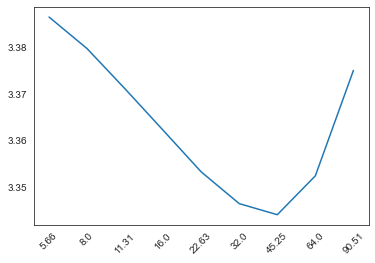

In [20]:
print("alpha_range: %.2f - %.2f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))
print('alfa = %.2f' % (ridge_alpha_search.best_params_['alpha']))
print('best_cv_mae = %.3f' % (-ridge_alpha_search.best_score_))

plt.xticks(range(len(l_alpha)), np.round(l_alpha, 2), rotation=45)
_ = plt.plot( -ridge_alpha_search.cv_results_['mean_test_score'])

## Testing the final model

We do it first by CV.

In [21]:
best_alpha = ridge_alpha_search.best_params_['alpha']
lr_m = Ridge(alpha=best_alpha)

scores = cross_val_score(lr_m, x, y, scoring="neg_mean_absolute_error", cv=kf, n_jobs=2)

print("mae_mean: %.3f\t\tmae_std: %.3f" % (-scores.mean(), scores.std()))

mae_mean: 3.327		mae_std: 0.452


We can get CV fold predictions with `cross_val_predict`.

In [22]:
y_pred = np.clip( cross_val_predict(lr_m, x, y, cv=kf), 5., 50.)

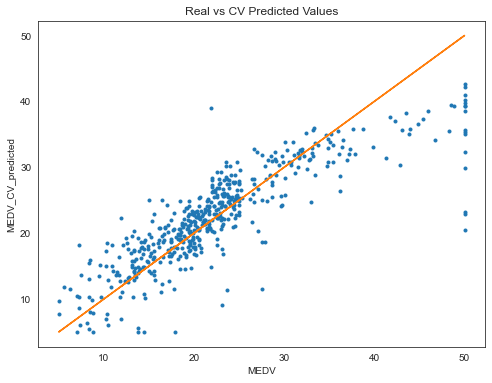

In [23]:
plt.figure( figsize=(8,6))

plt.title('Real vs CV Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_CV_predicted')
_ = plt.plot(y, y_pred, '.', y, y, '-')

### Residual histograms and relationship with targets

mae: 3.312


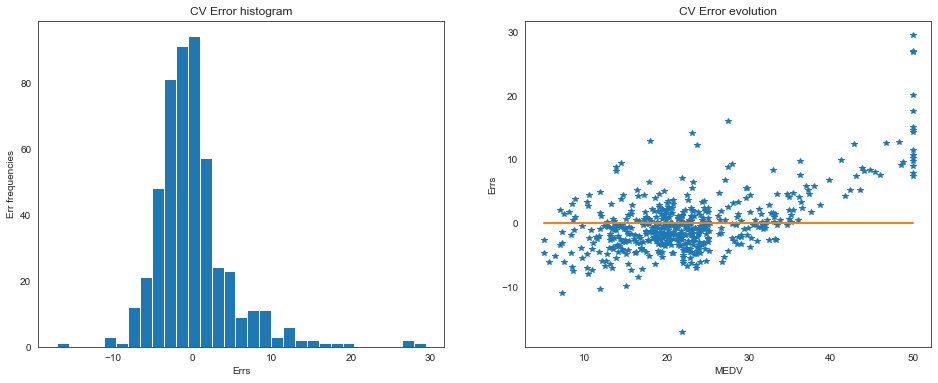

In [24]:
err = y - y_pred

print("mae: %.3f" % (abs(err).mean()) )

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("MEDV")
plt.ylabel("Errs")
_ = plt.plot(y, err, '*', y, 0.*y, '-')

plt.show()

## Multilayer Perceptons

Just getting started!

#### Scale the data

In [25]:
sc = StandardScaler()

x = sc.fit_transform(boston['data'])
y = boston['target']

####  Define and fit a first MLP

In [26]:
hidden_layer_sizes = (20, 20)
alpha = 1.e-2

#solver: lbfgs para problemas pequeños, adam para problemas grandes
mlp_m =  MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                      activation='relu', 
                      solver='lbfgs', 
                      alpha=alpha,
                      #early_stopping=True,
                      tol=1.e-3, 
                      max_iter=5000)

mlp_m.fit(x, y)

C:\Users\josed\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(alpha=0.01, hidden_layer_sizes=(20, 20), max_iter=5000,
             solver='lbfgs', tol=0.001)

What do we have in mlp_m?

In [27]:
print("weight_structure")
print(mlp_m.coefs_[0].shape)
print(mlp_m.coefs_[1].shape)
print(mlp_m.coefs_[2].shape)

print("mlp_loss: %.3f" % mlp_m.loss_)

weight_structure
(13, 20)
(20, 20)
(20, 1)
mlp_loss: 0.030


#### Predict and evaluate by CV

MAE: 0.141


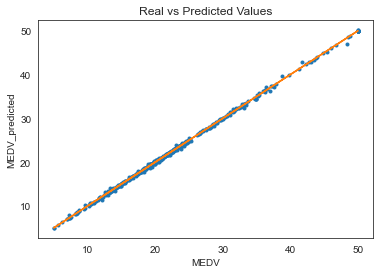

In [28]:
from sklearn.metrics import mean_absolute_error

y_pred = mlp_m.predict(x)

print("MAE: %.3f" % mean_absolute_error(y, y_pred))

plt.title('Real vs Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_predicted')
_ = plt.plot(y, y_pred, '.', y, y, '-')

A clear case of overfitting and of bad model performance evaluation!!

CV gives us a more sensible evaluation.

In [29]:
n_folds = 5
kf = KFold(n_folds, shuffle=True)

scores_mlp = cross_val_score(mlp_m, x, y.ravel(), scoring="neg_mean_absolute_error", cv=kf, n_jobs=-1)

In [30]:
print( ("mae_mean: %.3f" % -scores_mlp.mean()),  ("\tmae_std: %.3f" % scores_mlp.std()) )
print("scores:\n", -np.round(scores_mlp, 3))

mae_mean: 4.419 	mae_std: 0.610
scores:
 [5.325 4.914 4.254 3.765 3.836]


#### Analyze CV predictions

In [31]:
from sklearn.model_selection import cross_val_predict

y_pred_mlp_cv = np.clip( cross_val_predict(mlp_m, x, y.ravel(), cv=kf), 5., 50.)

C:\Users\josed\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\josed\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\josed\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of 

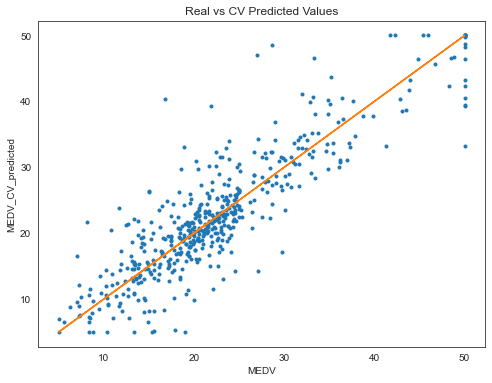

In [32]:
plt.figure( figsize=(8,6))

plt.title('Real vs CV Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_CV_predicted')
_ = plt.plot(y, y_pred_mlp_cv, '.', y, y, '-')

mae: 3.226


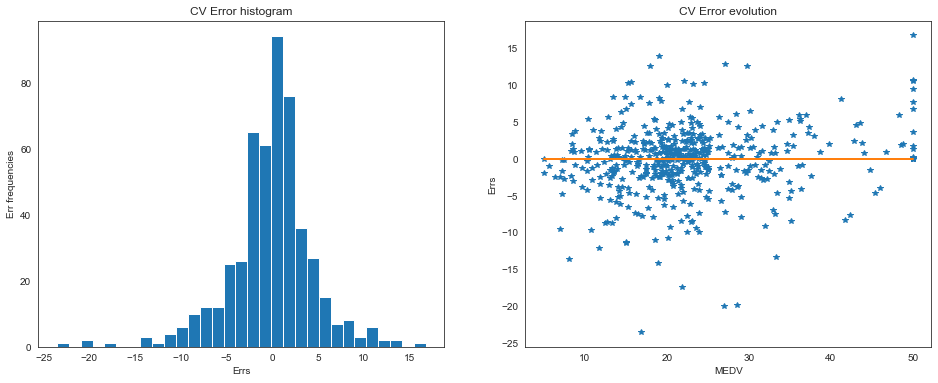

In [33]:
err = y - y_pred_mlp_cv

print("mae: %.3f" % (abs(err).mean()) )

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("MEDV")
plt.ylabel("Errs")
_ = plt.plot(y, err, '*', y, 0.*y, '-')

plt.show()

### Finding the optimal `alpha` by CV

We first improve on our definition of the mlp using a pipeline and scaling targets and then select the l2 penalty parameter `alpha` by CV.

We will exploit the model available in the `GridSearchCV` object.

In [34]:
# select alpha in mlp regression by CV
n_folds = 10
kf = KFold(n_folds, shuffle=True)

mlpr =  MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                     activation='relu', 
                     solver='adam', 
                     early_stopping=True,
                     tol=1.e-3, 
                     max_iter=5000)

regr = Pipeline(steps=[('std_sc', StandardScaler()),
                       ('mlp', mlpr)])
    
y_transformer = StandardScaler()
inner_estimator = TransformedTargetRegressor(regressor=regr,
                                             transformer=y_transformer)

l_alpha = [10.**k for k in range(-6, 7)]
param_grid = {'regressor__mlp__alpha': l_alpha}  
#'regressor__mlp__hidden_layer_sizes': [(20,), (20, 20), (20, 20, 20)]}


cv_estimator = GridSearchCV(inner_estimator, 
                            param_grid=param_grid, 
                            cv=kf, 
                            scoring='neg_mean_absolute_error',
                            return_train_score=True,
                            refit=True,
                            n_jobs=-1, 
                            verbose=1)

t_0 = time.time()
cv_estimator.fit(x, y)
t_1 = time.time() 
print("\nmlp_grid_search_time: %.2f" % ((t_1 - t_0)/60.))
        
# saving alpha_search in a pickle    
f = gzip.open('mlp_alpha_search_results.pkz', mode='wb', compresslevel=9)
pickle.dump(cv_estimator, f, protocol=3)
f.close()

Fitting 10 folds for each of 13 candidates, totalling 130 fits

mlp_grid_search_time: 0.23


alpha_range: 0.00 - 1000000.00
best_alpha = 0.00
best_cv_mae = 2.851


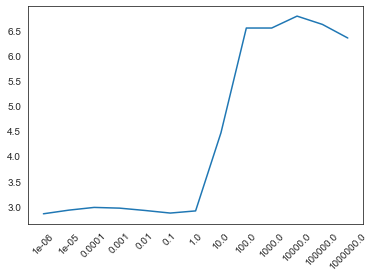

In [35]:
f = gzip.open('mlp_alpha_search_results.pkz', mode='rb')
cv_estimator = pickle.load(f)
f.close()

print("alpha_range: %.2f - %.2f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))
print('best_alpha = %.2f' % (cv_estimator.best_params_['regressor__mlp__alpha']))
print('best_cv_mae = %.3f' % (-cv_estimator.best_score_))

plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
_ = plt.plot( -cv_estimator.cv_results_['mean_test_score'])

### Testing the optimal model

In [36]:
y_pred_mlp_cv = np.clip( cross_val_predict(cv_estimator.best_estimator_, x, y, cv=kf, n_jobs=-1), 5., 50.)

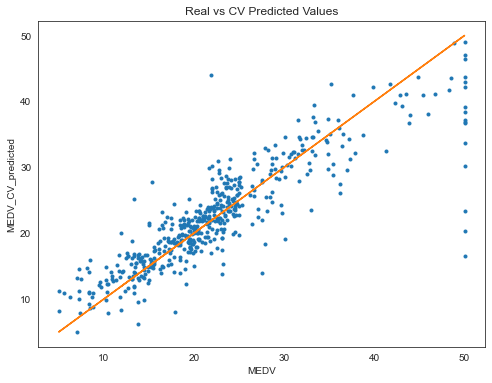

In [37]:
plt.figure( figsize=(8,6))

plt.title('Real vs CV Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_CV_predicted')
_ = plt.plot(y, y_pred_mlp_cv, '.', y, y, '-')

mae: 2.892


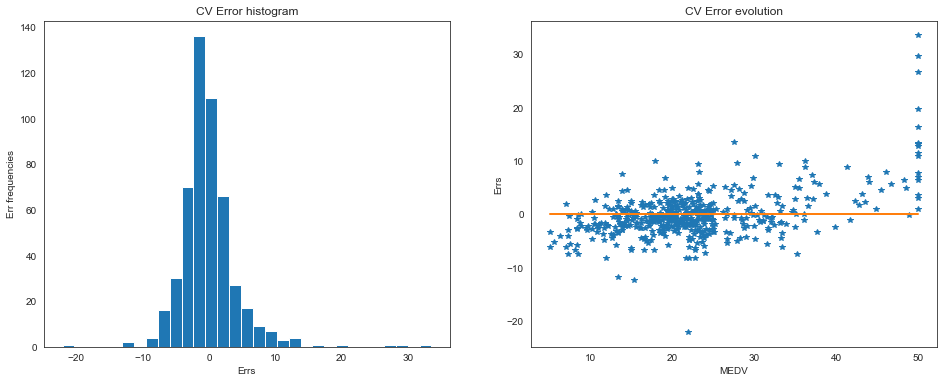

In [38]:
err = y - y_pred_mlp_cv

print("mae: %.3f" % (abs(err).mean()) )

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("MEDV")
plt.ylabel("Errs")
_ = plt.plot(y, err, '*', y, 0.*y, '-')

plt.show()

## A second try

Our previous MLP was OK, but not great. Let's make a second try using the `lbfgs` solver.

### Finding the optimal `alpha` by CV

We first improve on our definition of the mlp using a pipeline and scaling targets and then select the l2 penalty parameter `alpha` by CV.

We will exploit the model available in the `GridSearchCV` object.

In [39]:
# select alpha in mlp regression by CV
n_folds = 10
kf = KFold(n_folds, shuffle=True)

mlpr =  MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                     activation='relu', 
                     solver='lbfgs', 
                     #early_stopping=True,
                     tol=1.e-3, 
                     max_iter=5000)

regr = Pipeline(steps=[('std_sc', StandardScaler()),
                       ('mlp', mlpr)])
    
y_transformer = StandardScaler()
inner_estimator = TransformedTargetRegressor(regressor=regr,
                                             transformer=y_transformer)

l_alpha = [10.**k for k in range(-6, 7)]
param_grid = {'regressor__mlp__alpha': l_alpha}  
#'regressor__mlp__hidden_layer_sizes': [(20,), (20, 20), (20, 20, 20)]}


cv_estimator = GridSearchCV(inner_estimator, 
                            param_grid=param_grid, 
                            cv=kf, 
                            scoring='neg_mean_absolute_error',
                            return_train_score=True,
                            refit=True,
                            n_jobs=-1, 
                            verbose=1)

t_0 = time.time()
cv_estimator.fit(x, y)
t_1 = time.time() 
print("\nmlp_grid_search_time: %.2f" % ((t_1 - t_0)/60.))
        
# saving alpha_search in a pickle    
f = gzip.open('mlp_alpha_search_results.pkz', mode='wb', compresslevel=9)
pickle.dump(cv_estimator, f, protocol=3)
f.close()

Fitting 10 folds for each of 13 candidates, totalling 130 fits

mlp_grid_search_time: 0.41


alpha_range: 0.00 - 1000000.00
best_alpha = 1.00
best_cv_mae = 2.075


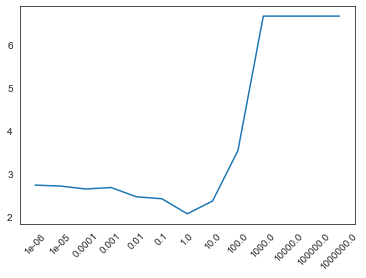

In [40]:
f = gzip.open('mlp_alpha_search_results.pkz', mode='rb')
cv_estimator = pickle.load(f)
f.close()

print("alpha_range: %.2f - %.2f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))
print('best_alpha = %.2f' % (cv_estimator.best_params_['regressor__mlp__alpha']))
print('best_cv_mae = %.3f' % (-cv_estimator.best_score_))

plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
_ = plt.plot( -cv_estimator.cv_results_['mean_test_score'])

### Testing the second optimal model

In [41]:
y_pred_mlp_cv = np.clip( cross_val_predict(cv_estimator.best_estimator_, x, y, cv=kf, n_jobs=-1), 5., 50.)

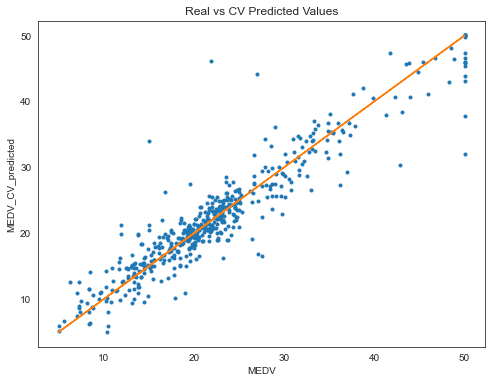

In [42]:
plt.figure( figsize=(8,6))

plt.title('Real vs CV Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_CV_predicted')
_ = plt.plot(y, y_pred_mlp_cv, '.', y, y, '-')

mae: 2.055


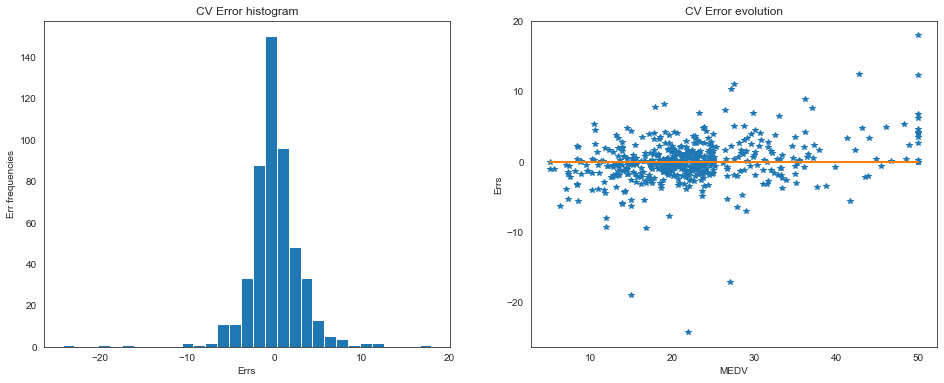

In [43]:
err = y - y_pred_mlp_cv

print("mae: %.3f" % (abs(err).mean()) )

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("MEDV")
plt.ylabel("Errs")
_ = plt.plot(y, err, '*', y, 0.*y, '-')

plt.show()

## MLP weight distribution

We compare the initial MLP weights and the final ones.

To get the approximately initial weights we perform a single MLP iteration.

In [44]:
#reload and rescale data
x = sc.fit_transform(boston['data'])
y = boston['target']

# Initial weights: weights after one iteration
mlp_m_new =  MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                          activation='relu', 
                          solver='adam', 
                          alpha=alpha,
                          early_stopping=True,
                          warm_start=False,    
                          tol=1.e4, 
                          max_iter=1)

In [45]:
mlp_m_new.fit(x, y)
#check just one iter
print(mlp_m_new.n_iter_)

1


C:\Users\josed\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Drawing the hidden weight histograms we can appreciate an approximately uniform distribution.

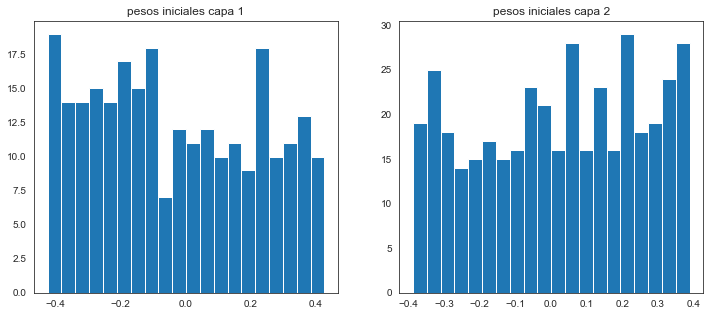

In [46]:
plt.figure( figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("pesos iniciales capa 1")
_ = plt.hist(mlp_m_new.coefs_[0].ravel(), bins=20)

plt.subplot(1, 2, 2)
plt.title("pesos iniciales capa 2")
_ = plt.hist(mlp_m_new.coefs_[1].ravel(), bins=20)

plt.show()

Drawing the hidden and output weight heatmaps we can see the same strucuture (notice the relatively few zero values).

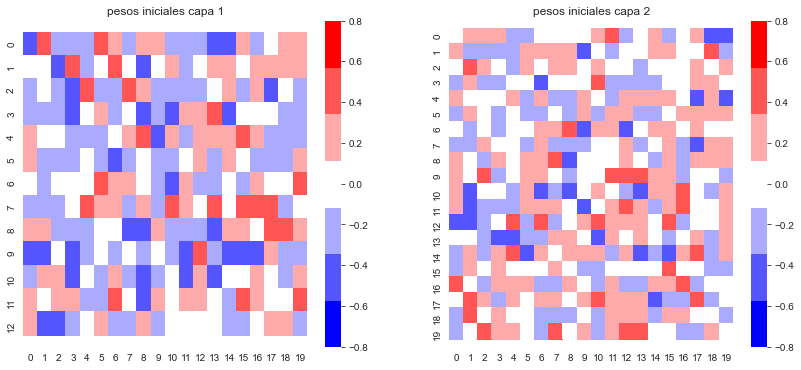

In [47]:
cMap = plt.cm.get_cmap("bwr",lut=7) 
plt.figure( figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title("pesos iniciales capa 1")
h_map_0 = sns.heatmap(mlp_m_new.coefs_[0], vmin=-0.8, vmax=0.8, cmap=cMap)
cbar = h_map_0.collections[0].colorbar
l_ticks = [k/10. for k in range(-8, 9, 2)]
cbar.set_ticks(l_ticks)

bottom, top = h_map_0.get_ylim()
h_map_0.set_ylim(bottom + 0.5, top - 0.5)


plt.subplot(1, 2, 2)
plt.title("pesos iniciales capa 2")
h_map_1 = sns.heatmap(mlp_m_new.coefs_[1], vmin=-0.8, vmax=0.8, cmap=cMap)
cbar = h_map_1.collections[0].colorbar
l_ticks = [k/10. for k in range(-8, 9, 2)]
cbar.set_ticks(l_ticks)

bottom, top = h_map_1.get_ylim()
h_map_1.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

After a longer training the weight distribution changes.

In [48]:
mlp_m_new =  MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                          activation='relu', 
                          solver='adam', 
                          alpha=alpha,
                          early_stopping=True,
                          warm_start=False,    
                          tol=1.e-8, 
                          max_iter=10000)

In [49]:
mlp_m_new.fit(x, y)

MLPRegressor(alpha=0.01, early_stopping=True, hidden_layer_sizes=(20, 20),
             max_iter=10000, tol=1e-08)

The weight histograms show a sharper maximum at 0.

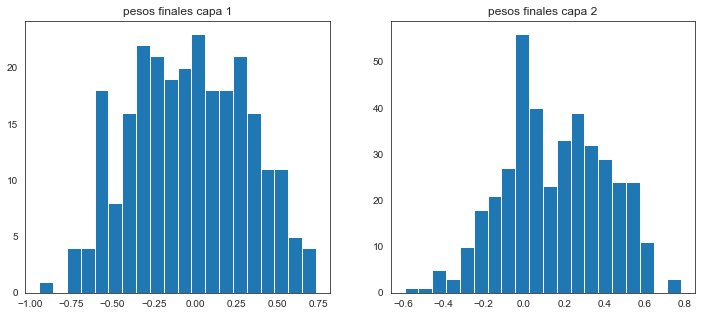

In [50]:
plt.figure( figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("pesos finales capa 1")
_ = plt.hist(mlp_m_new.coefs_[0].ravel(), bins=20)

plt.subplot(1, 2, 2)
plt.title("pesos finales capa 2")
_ = plt.hist(mlp_m_new.coefs_[1].ravel(), bins=20)

plt.show()

An the number of white points in the heatmaps also increases.

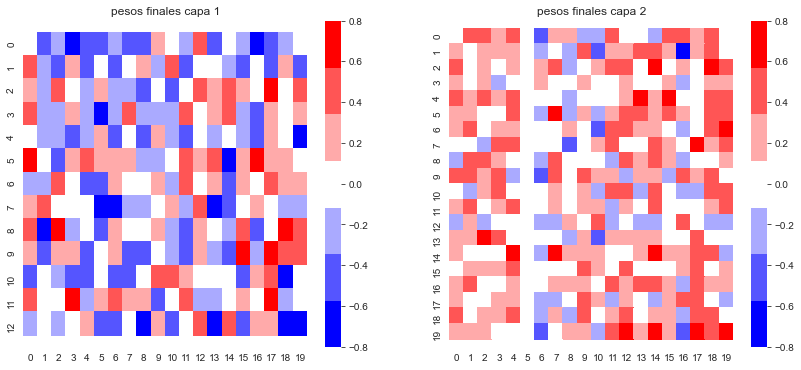

In [51]:
cMap = plt.cm.get_cmap("bwr",lut=7) 

plt.figure( figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title("pesos finales capa 1")
h_map_0 = sns.heatmap(mlp_m_new.coefs_[0], vmin=-0.8, vmax=0.8, cmap=cMap)
cbar = h_map_0.collections[0].colorbar
l_ticks = [k/10. for k in range(-8, 9, 2)]
cbar.set_ticks(l_ticks)

bottom, top = h_map_0.get_ylim()
h_map_0.set_ylim(bottom + 0.5, top - 0.5)

plt.subplot(1, 2, 2)
plt.title("pesos finales capa 2")
h_map_1 = sns.heatmap(mlp_m_new.coefs_[1], vmin=-0.8, vmax=0.8, cmap=cMap)
cbar = h_map_1.collections[0].colorbar
l_ticks = [k/10. for k in range(-8, 9, 2)]
cbar.set_ticks(l_ticks)

bottom, top = h_map_1.get_ylim()
h_map_1.set_ylim(bottom + 0.5, top - 0.5)

plt.show()